In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/squatnow/squat/bad_back_round/0922_squat_000075.mp4
/kaggle/input/squatnow/squat/bad_back_round/0918_squat_000058.mp4
/kaggle/input/squatnow/squat/bad_back_round/1018_squat_000226.mp4
/kaggle/input/squatnow/squat/bad_back_round/1015_squat_000132.mp4
/kaggle/input/squatnow/squat/bad_back_round/1015_squat_000138.mp4
/kaggle/input/squatnow/squat/bad_back_round/1022_squat_000129.mp4
/kaggle/input/squatnow/squat/bad_back_round/1025_squat_000226.mp4
/kaggle/input/squatnow/squat/bad_back_round/1015_squat_000136.mp4
/kaggle/input/squatnow/squat/bad_back_round/1018_squat_000129.mp4
/kaggle/input/squatnow/squat/bad_back_round/1025_squat_000225.mp4
/kaggle/input/squatnow/squat/bad_back_round/0922_squat_000115.mp4
/kaggle/input/squatnow/squat/bad_back_round/0926_squat_000033.mp4
/kaggle/input/squatnow/squat/bad_back_round/1022_squat_000031.mp4
/kaggle/input/squatnow/squat/bad_back_round/0918_squat_000062.mp4
/kaggle/input/squatnow/squat/bad_back_round/1018_squat_000128.mp4
/kaggle/in

In [2]:
pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 49.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google-

In [3]:
import os
import glob
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


2025-06-10 10:35:55.521352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749551755.997247      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749551756.138567      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import mediapipe as mp
import cv2
import numpy as np

mp_pose = mp.solutions.pose

def extract_pose_landmarks(video_path, max_frames=100):
    cap = cv2.VideoCapture(video_path)
    pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

    landmarks_list = []
    frame_count = 0

    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = pose.process(frame_rgb)

        if result.pose_landmarks:
            keypoints = []
            for lm in result.pose_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z, lm.visibility])
            landmarks_list.append(keypoints)

        frame_count += 1

    cap.release()
    pose.close()

    # Pad to max_frames
    while len(landmarks_list) < max_frames:
        landmarks_list.append([0] * 132)  # 33 landmarks × 4 features

    return np.array(landmarks_list)


In [5]:
import os
import glob

def process_videos(folder, label, max_frames=100):
    data = []
    for video_path in glob.glob(os.path.join(folder, "*.mp4")):
        sequence = extract_pose_landmarks(video_path, max_frames=max_frames)
        data.append((sequence, label))
    return data


In [6]:
# Label mapping
label_map = {
    'bad_back_round': 0,
    'bad_back_wrap': 1,
    'bad_inner_thigh': 2,
    'correct': 3,
    'shallow': 4
}

# dataset path 
base_path = '/kaggle/input/squatnow/squat'

# Collect all data
full_data = []
for class_name, label in label_map.items():
    folder_path = os.path.join(base_path, class_name)
    full_data.extend(process_videos(folder_path, label))


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1749551772.412811     110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1749551772.478472     110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1749551772.510981     110 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
W0000 00:00:1749551775.790129     121 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1749551775.847832     121 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:

In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

X, y = zip(*full_data)
X = np.array(X)
y = np.array(y)

# Convert labels to one-hot vectors
y = to_categorical(y, num_classes=len(label_map))

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class AdditiveAttention(Layer):
    def __init__(self, units):
        super(AdditiveAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, values, query):  # values = LSTM outputs, query = last LSTM hidden state
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(query_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

sequence_input = Input(shape=(X.shape[1], X.shape[2]))  # (timesteps, features)

# LSTM Encoder
lstm_out, state_h, state_c = LSTM(64, return_sequences=True, return_state=True)(sequence_input)

# Attention
attention_layer = AdditiveAttention(units=32)
context_vector, attention_weights = attention_layer(lstm_out, state_h)

# Classification Head
x = Dropout(0.3)(context_vector)
output = Dense(len(label_map), activation='softmax')(x)

model = Model(inputs=sequence_input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1749553846.284481      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749553846.285219      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100, 132)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 100, 64),      │         50,432 │ input_layer[0][0]      │
│                           │ (None, 64), (None,     │                │                        │
│                           │ 64)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ additive_attention        │ [(None, 64), (None,    │          4,193 │ lstm[0][0], lstm[0][1] │
│ (AdditiveAttention)       │ 100, 1)]               │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ additive_attention[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 5)              │            325 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 54,950 (214.65 KB)

 Trainable params: 54,950 (214.65 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=8
)

Epoch 1/25


I0000 00:00:1749553852.150315    4934 cuda_dnn.cc:529] Loaded cuDNN version 90300


60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1840 - loss: 1.6714 - val_accuracy: 0.1901 - val_loss: 1.6512
Epoch 2/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2545 - loss: 1.5795 - val_accuracy: 0.3388 - val_loss: 1.4423
Epoch 3/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3300 - loss: 1.4314 - val_accuracy: 0.3884 - val_loss: 1.3561
Epoch 4/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3824 - loss: 1.2598 - val_accuracy: 0.4380 - val_loss: 1.3139
Epoch 5/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4374 - loss: 1.2643 - val_accuracy: 0.4132 - val_loss: 1.2988
Epoch 6/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4559 - loss: 1.2032 - val_accuracy: 0.4545 - val_loss: 1.2114
Epoch 7/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4979 - loss: 1.1640 - val_accuracy: 0.4215 - val_loss: 1.2147
Epoch 8/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5761 - loss: 1.0741 - val_accuracy: 0.4298 - val_loss: 1.2266

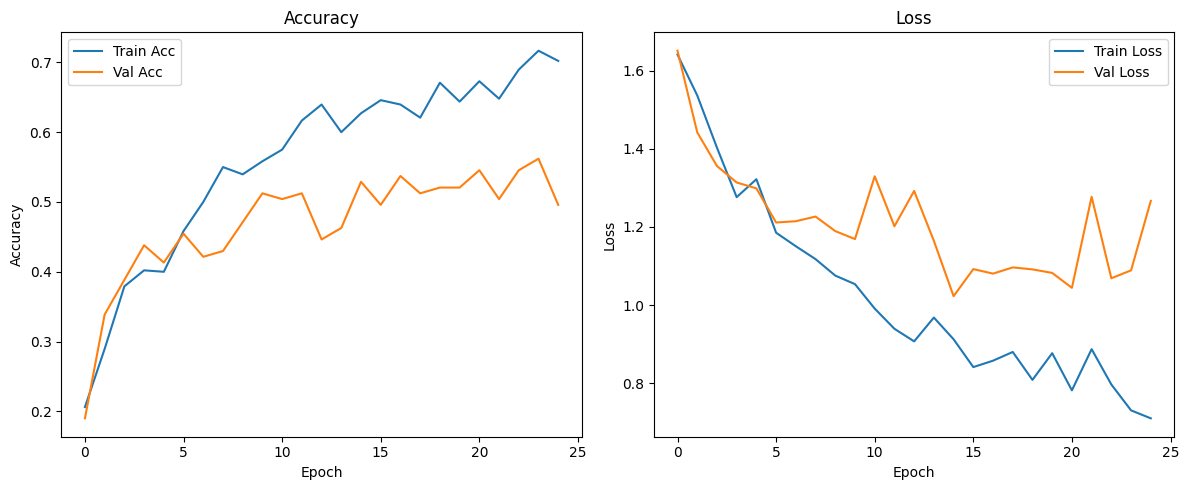

In [11]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


we can clearly see that the validation loss hasn't been following the descent of the training loss as of epoch 5.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
                 precision    recall  f1-score   support

 bad_back_round       0.67      0.64      0.65        22
  bad_back_wrap       0.41      0.48      0.44        25
bad_inner_thigh       0.67      0.32      0.43        25
        correct       0.31      0.17      0.22        24
        shallow       0.48      0.88      0.62        25

       accuracy                           0.50       121
      macro avg       0.51      0.50      0.47       121
   weighted avg       0.50      0.50      0.47       121



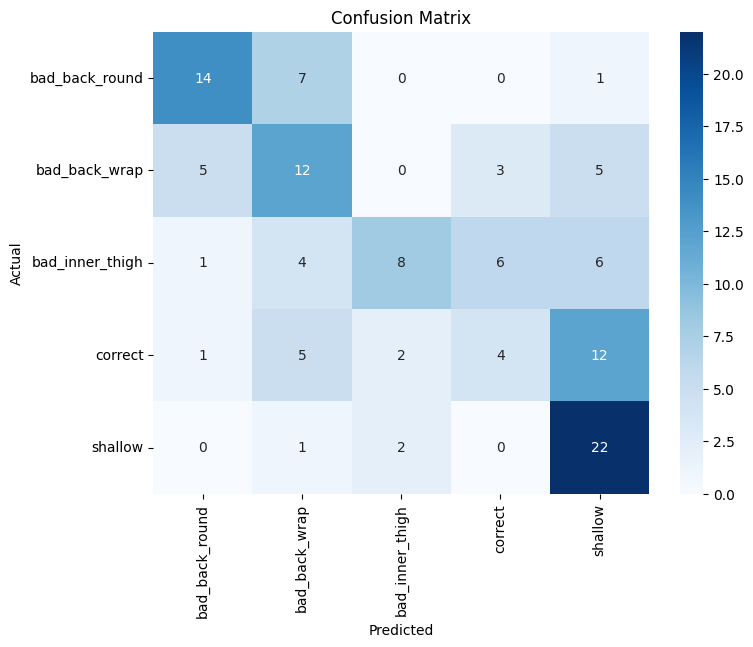

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=label_map.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


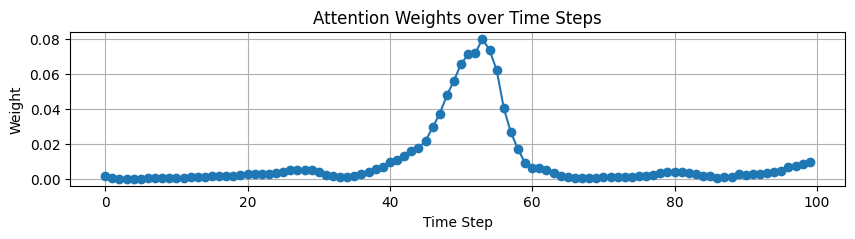

In [14]:
def visualize_attention(model, sample):
    # Get intermediate outputs
    lstm_layer = model.layers[1]
    attn_layer = model.layers[2]

    lstm_out, state_h, state_c = lstm_layer(sample)
    _, attn_weights = attn_layer(lstm_out, state_h)

    # Plot attention weights
    plt.figure(figsize=(10, 2))
    plt.plot(attn_weights.numpy().squeeze(), marker='o')
    plt.title('Attention Weights over Time Steps')
    plt.xlabel('Time Step')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.show()

# Example: visualize attention on first validation sample
sample = X_val[0:1]  # shape (1, time, features)
visualize_attention(model, sample)


we'll do a hyperparameter search using optuna

In [13]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [15]:
import optuna
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [29]:
class AdditiveAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(AdditiveAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, values, query):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(query_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


In [32]:
def objective(trial):
    lstm_units = trial.suggest_int("lstm_units", 32, 128)
    attention_units = trial.suggest_int("attention_units", 16, 64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16, 32])

    # Define model
    sequence_input = Input(shape=(X.shape[1], X.shape[2]))
    lstm_out, state_h, state_c = LSTM(lstm_units, return_sequences=True, return_state=True)(sequence_input)
    context_vector, _ = AdditiveAttention(attention_units)(lstm_out, state_h)
    x = Dropout(dropout_rate)(context_vector)
    output = Dense(len(label_map), activation='softmax')(x)

    model = Model(inputs=sequence_input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=batch_size,
        verbose=1
    )

    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy


In [33]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best Trial:")
print(f"  Accuracy: {study.best_trial.value:.4f}")
print("  Hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-06-10 11:38:10,899] A new study created in memory with name: no-name-bb96327d-dd98-4c6a-b7c7-6d74c0f2ec1d


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.2206 - loss: 1.7207 - val_accuracy: 0.2066 - val_loss: 1.6456
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1834 - loss: 1.6987 - val_accuracy: 0.2066 - val_loss: 1.6288
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1732 - loss: 1.6877 - val_accuracy: 0.2149 - val_loss: 1.6178
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2016 - loss: 1.6626 - val_accuracy: 0.2231 - val_loss: 1.6116
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3084 - loss: 1.5944 - val_accuracy: 0.2314 - val_loss: 1.6083
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2218 - loss: 1.6412 - val_accuracy: 0.2314 - val_loss: 1.6047
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2319 - loss: 1.6381 - val_accuracy: 0.2479 - val_loss: 1.6029
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2525 - loss: 1.6299 - val_accuracy: 0.2562 - v

[I 2025-06-10 11:38:43,808] Trial 0 finished with value: 0.4545454680919647 and parameters: {'lstm_units': 65, 'attention_units': 53, 'dropout_rate': 0.41044626969983566, 'learning_rate': 2.107848958591521e-05, 'batch_size': 8}. Best is trial 0 with value: 0.4545454680919647.


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.1895 - loss: 1.6399 - val_accuracy: 0.2479 - val_loss: 1.6022
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2528 - loss: 1.6278 - val_accuracy: 0.2645 - val_loss: 1.5964
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1964 - loss: 1.6360 - val_accuracy: 0.3058 - val_loss: 1.5927
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2610 - loss: 1.5981 - val_accuracy: 0.2975 - val_loss: 1.5896
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1828 - loss: 1.6315 - val_accuracy: 0.3140 - val_loss: 1.5878
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2039 - loss: 1.6064 - val_accuracy: 0.2810 - val_loss: 1.5853
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3044 - loss: 1.5759 - val_accuracy: 0.2810 - val_loss: 1.5834
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2385 - loss: 1.6101 - val_accuracy: 0.2975 - v

[I 2025-06-10 11:39:03,965] Trial 1 finished with value: 0.44628098607063293 and parameters: {'lstm_units': 86, 'attention_units': 53, 'dropout_rate': 0.1923499580140915, 'learning_rate': 2.0918920619224864e-05, 'batch_size': 16}. Best is trial 0 with value: 0.4545454680919647.


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.2048 - loss: 1.6534 - val_accuracy: 0.1818 - val_loss: 1.6397
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1804 - loss: 1.6403 - val_accuracy: 0.2479 - val_loss: 1.6181
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2523 - loss: 1.6153 - val_accuracy: 0.2562 - val_loss: 1.6078
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2898 - loss: 1.5838 - val_accuracy: 0.2975 - val_loss: 1.5902
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2566 - loss: 1.5782 - val_accuracy: 0.2893 - val_loss: 1.5685
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2772 - loss: 1.5462 - val_accuracy: 0.3058 - val_loss: 1.5295
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3426 - loss: 1.4747 - val_accuracy: 0.4050 - val_loss: 1.4352
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3783 - loss: 1.4266 - val_accuracy: 0.3719 - v

[I 2025-06-10 11:39:17,641] Trial 2 finished with value: 0.4710743725299835 and parameters: {'lstm_units': 37, 'attention_units': 62, 'dropout_rate': 0.23295907428956478, 'learning_rate': 0.0004791823654408088, 'batch_size': 32}. Best is trial 2 with value: 0.4710743725299835.


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.1979 - loss: 1.6514 - val_accuracy: 0.2231 - val_loss: 1.6340
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1899 - loss: 1.6362 - val_accuracy: 0.1983 - val_loss: 1.6199
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2275 - loss: 1.6035 - val_accuracy: 0.2066 - val_loss: 1.6108
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2167 - loss: 1.6005 - val_accuracy: 0.2314 - val_loss: 1.6051
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2326 - loss: 1.5973 - val_accuracy: 0.2727 - val_loss: 1.5989
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2534 - loss: 1.5941 - val_accuracy: 0.2727 - val_loss: 1.5943
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2983 - loss: 1.5869 - val_accuracy: 0.2645 - val_loss: 1.5901
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2508 - loss: 1.5797 - val_accuracy: 0.2893 - v

[I 2025-06-10 11:39:37,684] Trial 3 finished with value: 0.5123966932296753 and parameters: {'lstm_units': 46, 'attention_units': 17, 'dropout_rate': 0.21694408697343556, 'learning_rate': 5.895796217975984e-05, 'batch_size': 16}. Best is trial 3 with value: 0.5123966932296753.


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.1582 - loss: 1.8359 - val_accuracy: 0.2231 - val_loss: 1.6597
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1750 - loss: 1.7123 - val_accuracy: 0.2645 - val_loss: 1.6222
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1908 - loss: 1.6735 - val_accuracy: 0.2066 - val_loss: 1.6130
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2090 - loss: 1.6255 - val_accuracy: 0.2314 - val_loss: 1.6057
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2160 - loss: 1.6486 - val_accuracy: 0.2397 - val_loss: 1.5994
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1975 - loss: 1.6389 - val_accuracy: 0.2645 - val_loss: 1.5940
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2466 - loss: 1.6211 - val_accuracy: 0.2397 - val_loss: 1.5906
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2418 - loss: 1.6108 - val_accuracy: 0.2645 - v

[I 2025-06-10 11:39:57,426] Trial 4 finished with value: 0.4958677589893341 and parameters: {'lstm_units': 44, 'attention_units': 19, 'dropout_rate': 0.3167337267736845, 'learning_rate': 9.976903001836811e-05, 'batch_size': 16}. Best is trial 3 with value: 0.5123966932296753.


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.1765 - loss: 1.7487 - val_accuracy: 0.2066 - val_loss: 1.5972
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2257 - loss: 1.6134 - val_accuracy: 0.3306 - val_loss: 1.4847
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3674 - loss: 1.4590 - val_accuracy: 0.3140 - val_loss: 1.4428
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3156 - loss: 1.4837 - val_accuracy: 0.4215 - val_loss: 1.4265
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3924 - loss: 1.3994 - val_accuracy: 0.4050 - val_loss: 1.3485
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4012 - loss: 1.3163 - val_accuracy: 0.4215 - val_loss: 1.3389
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3797 - loss: 1.3413 - val_accuracy: 0.4711 - val_loss: 1.2946
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4742 - loss: 1.2637 - val_accuracy: 0.4463 - v

[I 2025-06-10 11:40:11,110] Trial 5 finished with value: 0.5289255976676941 and parameters: {'lstm_units': 46, 'attention_units': 48, 'dropout_rate': 0.3502726825638801, 'learning_rate': 0.004823931501395815, 'batch_size': 32}. Best is trial 5 with value: 0.5289255976676941.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1795 - loss: 1.7282 - val_accuracy: 0.2066 - val_loss: 1.6771
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1839 - loss: 1.7173 - val_accuracy: 0.1983 - val_loss: 1.6583
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1621 - loss: 1.6493 - val_accuracy: 0.2066 - val_loss: 1.6448
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2523 - loss: 1.6366 - val_accuracy: 0.1901 - val_loss: 1.6350
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2334 - loss: 1.6125 - val_accuracy: 0.2149 - val_loss: 1.6286
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2470 - loss: 1.6262 - val_accuracy: 0.2149 - val_loss: 1.6236
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2328 - loss: 1.6091 - val_accuracy: 0.2149 - val_loss: 1.6197
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2179 - loss: 1.6340 - val_accuracy: 0

[I 2025-06-10 11:41:09,108] Trial 6 finished with value: 0.28099173307418823 and parameters: {'lstm_units': 41, 'attention_units': 19, 'dropout_rate': 0.2971454156082549, 'learning_rate': 1.3757102086812046e-05, 'batch_size': 4}. Best is trial 5 with value: 0.5289255976676941.


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.2254 - loss: 1.6324 - val_accuracy: 0.2231 - val_loss: 1.6056
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1940 - loss: 1.6296 - val_accuracy: 0.2231 - val_loss: 1.5974
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2648 - loss: 1.6038 - val_accuracy: 0.2645 - val_loss: 1.5896
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1860 - loss: 1.6221 - val_accuracy: 0.3058 - val_loss: 1.5822
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2156 - loss: 1.6114 - val_accuracy: 0.3058 - val_loss: 1.5739
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2636 - loss: 1.5933 - val_accuracy: 0.3058 - val_loss: 1.5650
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2444 - loss: 1.5979 - val_accuracy: 0.3471 - val_loss: 1.5548
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2229 - loss: 1.5840 - val_accuracy: 0.3636 - v

[I 2025-06-10 11:41:22,966] Trial 7 finished with value: 0.5123966932296753 and parameters: {'lstm_units': 84, 'attention_units': 32, 'dropout_rate': 0.32411258641234864, 'learning_rate': 6.841823926184323e-05, 'batch_size': 32}. Best is trial 5 with value: 0.5289255976676941.


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2578 - loss: 1.7026 - val_accuracy: 0.2066 - val_loss: 1.6028
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2291 - loss: 1.6054 - val_accuracy: 0.2727 - val_loss: 1.5454
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2950 - loss: 1.5240 - val_accuracy: 0.3471 - val_loss: 1.3995
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3589 - loss: 1.4035 - val_accuracy: 0.4463 - val_loss: 1.3342
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4259 - loss: 1.2814 - val_accuracy: 0.3306 - val_loss: 1.5051
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3520 - loss: 1.3838 - val_accuracy: 0.3802 - val_loss: 1.3591
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4591 - loss: 1.2474 - val_accuracy: 0.4132 - val_loss: 1.2747
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5290 - loss: 1.1483 - val_accuracy: 0.4132 - v

[I 2025-06-10 11:41:56,289] Trial 8 finished with value: 0.6198347210884094 and parameters: {'lstm_units': 101, 'attention_units': 54, 'dropout_rate': 0.41230098001571314, 'learning_rate': 0.0016912968623338978, 'batch_size': 8}. Best is trial 8 with value: 0.6198347210884094.


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1823 - loss: 1.7111 - val_accuracy: 0.2645 - val_loss: 1.5893
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2499 - loss: 1.5868 - val_accuracy: 0.3719 - val_loss: 1.5163
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3180 - loss: 1.4803 - val_accuracy: 0.3554 - val_loss: 1.4621
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3628 - loss: 1.3756 - val_accuracy: 0.3636 - val_loss: 1.3423
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4397 - loss: 1.3015 - val_accuracy: 0.4050 - val_loss: 1.3417
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4120 - loss: 1.2674 - val_accuracy: 0.3967 - val_loss: 1.3243
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5024 - loss: 1.1404 - val_accuracy: 0.4793 - val_loss: 1.2082
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5368 - loss: 1.1640 - val_accuracy: 0.4876 - v

[I 2025-06-10 11:42:29,467] Trial 9 finished with value: 0.6115702390670776 and parameters: {'lstm_units': 100, 'attention_units': 51, 'dropout_rate': 0.3925589573905629, 'learning_rate': 0.001481815985746006, 'batch_size': 8}. Best is trial 8 with value: 0.6198347210884094.


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2170 - loss: 1.7650 - val_accuracy: 0.1983 - val_loss: 1.6185
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2307 - loss: 1.6198 - val_accuracy: 0.2066 - val_loss: 1.6082
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2106 - loss: 1.6194 - val_accuracy: 0.1983 - val_loss: 1.6002
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2268 - loss: 1.6118 - val_accuracy: 0.2231 - val_loss: 1.6061
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2297 - loss: 1.6096 - val_accuracy: 0.2149 - val_loss: 1.6183
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2136 - loss: 1.6318 - val_accuracy: 0.2397 - val_loss: 1.5993
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2439 - loss: 1.5901 - val_accuracy: 0.1983 - val_loss: 1.5959
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2261 - loss: 1.5946 - val_accuracy: 0.1901 - v

[I 2025-06-10 11:43:04,389] Trial 10 finished with value: 0.5206611752510071 and parameters: {'lstm_units': 126, 'attention_units': 36, 'dropout_rate': 0.49241354132892096, 'learning_rate': 0.006129043186767805, 'batch_size': 8}. Best is trial 8 with value: 0.6198347210884094.


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1819 - loss: 1.7754 - val_accuracy: 0.2810 - val_loss: 1.5725
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2937 - loss: 1.5400 - val_accuracy: 0.3554 - val_loss: 1.4364
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3726 - loss: 1.4101 - val_accuracy: 0.3554 - val_loss: 1.3417
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4073 - loss: 1.3293 - val_accuracy: 0.4050 - val_loss: 1.2758
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4406 - loss: 1.2575 - val_accuracy: 0.4132 - val_loss: 1.2949
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4891 - loss: 1.2292 - val_accuracy: 0.3967 - val_loss: 1.3048
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5112 - loss: 1.1186 - val_accuracy: 0.4463 - val_loss: 1.2699
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4758 - loss: 1.2522 - val_accuracy: 0.5207 - v

[I 2025-06-10 11:43:38,180] Trial 11 finished with value: 0.6198347210884094 and parameters: {'lstm_units': 110, 'attention_units': 63, 'dropout_rate': 0.4378645418319355, 'learning_rate': 0.0014515712780279386, 'batch_size': 8}. Best is trial 8 with value: 0.6198347210884094.


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1717 - loss: 1.7428 - val_accuracy: 0.2314 - val_loss: 1.5901
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2269 - loss: 1.5909 - val_accuracy: 0.2231 - val_loss: 1.5376
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3384 - loss: 1.4560 - val_accuracy: 0.4463 - val_loss: 1.3322
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4007 - loss: 1.3317 - val_accuracy: 0.3967 - val_loss: 1.3309
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4861 - loss: 1.2201 - val_accuracy: 0.3967 - val_loss: 1.3472
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4903 - loss: 1.2190 - val_accuracy: 0.4628 - val_loss: 1.2186
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5283 - loss: 1.1147 - val_accuracy: 0.4711 - val_loss: 1.2195
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5291 - loss: 1.1005 - val_accuracy: 0.5041 - v

[I 2025-06-10 11:44:11,565] Trial 12 finished with value: 0.64462810754776 and parameters: {'lstm_units': 114, 'attention_units': 64, 'dropout_rate': 0.49240600925351075, 'learning_rate': 0.0008936047301858019, 'batch_size': 8}. Best is trial 12 with value: 0.64462810754776.


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1501 - loss: 1.6958 - val_accuracy: 0.1983 - val_loss: 1.5938
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2365 - loss: 1.5936 - val_accuracy: 0.2810 - val_loss: 1.5367
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3096 - loss: 1.5485 - val_accuracy: 0.2810 - val_loss: 1.4708
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3767 - loss: 1.3906 - val_accuracy: 0.4298 - val_loss: 1.3495
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4290 - loss: 1.3190 - val_accuracy: 0.4793 - val_loss: 1.2601
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4856 - loss: 1.1679 - val_accuracy: 0.4298 - val_loss: 1.2448
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5409 - loss: 1.1306 - val_accuracy: 0.4793 - val_loss: 1.1939
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5449 - loss: 1.0372 - val_accuracy: 0.4959 - v

[I 2025-06-10 11:44:44,579] Trial 13 finished with value: 0.5785123705863953 and parameters: {'lstm_units': 128, 'attention_units': 64, 'dropout_rate': 0.49363255910550125, 'learning_rate': 0.0005399203735435526, 'batch_size': 8}. Best is trial 12 with value: 0.64462810754776.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2189 - loss: 1.6821 - val_accuracy: 0.2149 - val_loss: 1.6101
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2513 - loss: 1.5845 - val_accuracy: 0.2645 - val_loss: 1.4969
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2862 - loss: 1.4859 - val_accuracy: 0.2727 - val_loss: 1.4129
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4300 - loss: 1.2610 - val_accuracy: 0.3719 - val_loss: 1.3741
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4379 - loss: 1.3042 - val_accuracy: 0.4463 - val_loss: 1.2476
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5356 - loss: 1.1124 - val_accuracy: 0.3884 - val_loss: 1.4527
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5236 - loss: 1.1543 - val_accuracy: 0.5289 - val_loss: 1.1022
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5257 - loss: 1.0886 - val_accuracy

[I 2025-06-10 11:45:44,446] Trial 14 finished with value: 0.6363636255264282 and parameters: {'lstm_units': 105, 'attention_units': 44, 'dropout_rate': 0.11645365445059055, 'learning_rate': 0.0016851980457114823, 'batch_size': 4}. Best is trial 12 with value: 0.64462810754776.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2125 - loss: 1.6459 - val_accuracy: 0.1901 - val_loss: 1.6170
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3163 - loss: 1.5591 - val_accuracy: 0.3471 - val_loss: 1.4946
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4088 - loss: 1.3687 - val_accuracy: 0.4050 - val_loss: 1.3605
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4404 - loss: 1.2606 - val_accuracy: 0.4628 - val_loss: 1.2593
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5385 - loss: 1.1215 - val_accuracy: 0.4628 - val_loss: 1.2141
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5719 - loss: 1.0088 - val_accuracy: 0.4628 - val_loss: 1.2410
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6055 - loss: 0.9553 - val_accuracy: 0.4793 - val_loss: 1.1665
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6145 - loss: 0.9376 - val_accuracy: 

[I 2025-06-10 11:46:44,303] Trial 15 finished with value: 0.6694214940071106 and parameters: {'lstm_units': 114, 'attention_units': 42, 'dropout_rate': 0.1171647531731263, 'learning_rate': 0.00022834881362508068, 'batch_size': 4}. Best is trial 15 with value: 0.6694214940071106.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2120 - loss: 1.6543 - val_accuracy: 0.2397 - val_loss: 1.5918
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3034 - loss: 1.5545 - val_accuracy: 0.3058 - val_loss: 1.5103
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3803 - loss: 1.3825 - val_accuracy: 0.4215 - val_loss: 1.3406
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4612 - loss: 1.2513 - val_accuracy: 0.4050 - val_loss: 1.2823
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5140 - loss: 1.1345 - val_accuracy: 0.3884 - val_loss: 1.2695
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5397 - loss: 1.0842 - val_accuracy: 0.5207 - val_loss: 1.1509
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6305 - loss: 0.9512 - val_accuracy: 0.4876 - val_loss: 1.1721
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6223 - loss: 0.9382 - val_accuracy: 

[I 2025-06-10 11:47:44,220] Trial 16 finished with value: 0.6611570119857788 and parameters: {'lstm_units': 115, 'attention_units': 28, 'dropout_rate': 0.12796482340264143, 'learning_rate': 0.0002636180238998355, 'batch_size': 4}. Best is trial 15 with value: 0.6694214940071106.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2279 - loss: 1.6402 - val_accuracy: 0.2975 - val_loss: 1.5919
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2707 - loss: 1.5741 - val_accuracy: 0.3223 - val_loss: 1.5384
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3521 - loss: 1.4892 - val_accuracy: 0.3471 - val_loss: 1.4604
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3952 - loss: 1.3484 - val_accuracy: 0.4215 - val_loss: 1.3562
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4857 - loss: 1.2372 - val_accuracy: 0.4628 - val_loss: 1.2460
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4575 - loss: 1.1763 - val_accuracy: 0.4959 - val_loss: 1.2293
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5892 - loss: 1.0923 - val_accuracy: 0.4876 - val_loss: 1.2194
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5530 - loss: 1.0083 - val_accuracy: 0

[I 2025-06-10 11:48:43,278] Trial 17 finished with value: 0.64462810754776 and parameters: {'lstm_units': 92, 'attention_units': 29, 'dropout_rate': 0.11820404538791533, 'learning_rate': 0.00015476774196625262, 'batch_size': 4}. Best is trial 15 with value: 0.6694214940071106.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2134 - loss: 1.6519 - val_accuracy: 0.2645 - val_loss: 1.6010
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2782 - loss: 1.5957 - val_accuracy: 0.2562 - val_loss: 1.5620
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3253 - loss: 1.5220 - val_accuracy: 0.3471 - val_loss: 1.4932
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3759 - loss: 1.4262 - val_accuracy: 0.3719 - val_loss: 1.4234
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4621 - loss: 1.2935 - val_accuracy: 0.3967 - val_loss: 1.2938
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4977 - loss: 1.1841 - val_accuracy: 0.4959 - val_loss: 1.2515
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5413 - loss: 1.1631 - val_accuracy: 0.4463 - val_loss: 1.1815
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5854 - loss: 1.0896 - val_accuracy: 

[I 2025-06-10 11:49:43,627] Trial 18 finished with value: 0.6115702390670776 and parameters: {'lstm_units': 67, 'attention_units': 26, 'dropout_rate': 0.1612621161788208, 'learning_rate': 0.00019164434571214192, 'batch_size': 4}. Best is trial 15 with value: 0.6694214940071106.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2061 - loss: 1.6731 - val_accuracy: 0.2066 - val_loss: 1.6151
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2314 - loss: 1.5862 - val_accuracy: 0.2810 - val_loss: 1.5094
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3170 - loss: 1.4503 - val_accuracy: 0.3388 - val_loss: 1.5203
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4236 - loss: 1.2931 - val_accuracy: 0.4380 - val_loss: 1.3031
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5139 - loss: 1.1807 - val_accuracy: 0.4050 - val_loss: 1.3032
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5298 - loss: 1.1108 - val_accuracy: 0.4793 - val_loss: 1.2386
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5616 - loss: 1.0484 - val_accuracy: 0.4298 - val_loss: 1.2027
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5961 - loss: 0.9524 - val_accuracy: 

[I 2025-06-10 11:50:44,142] Trial 19 finished with value: 0.64462810754776 and parameters: {'lstm_units': 118, 'attention_units': 39, 'dropout_rate': 0.2620468547242986, 'learning_rate': 0.0002605429550325553, 'batch_size': 4}. Best is trial 15 with value: 0.6694214940071106.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2103 - loss: 1.6797 - val_accuracy: 0.3140 - val_loss: 1.5803
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2962 - loss: 1.5695 - val_accuracy: 0.2893 - val_loss: 1.4708
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3550 - loss: 1.4072 - val_accuracy: 0.3471 - val_loss: 1.4008
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3905 - loss: 1.3212 - val_accuracy: 0.4215 - val_loss: 1.3428
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5320 - loss: 1.1812 - val_accuracy: 0.3884 - val_loss: 1.2349
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5135 - loss: 1.1463 - val_accuracy: 0.4959 - val_loss: 1.2157
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5639 - loss: 1.0521 - val_accuracy: 0.4463 - val_loss: 1.1991
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5760 - loss: 1.0492 - val_accuracy: 0

[I 2025-06-10 11:51:44,340] Trial 20 finished with value: 0.6280992031097412 and parameters: {'lstm_units': 70, 'attention_units': 24, 'dropout_rate': 0.15696629040353305, 'learning_rate': 0.00038806592480283646, 'batch_size': 4}. Best is trial 15 with value: 0.6694214940071106.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1849 - loss: 1.6745 - val_accuracy: 0.2893 - val_loss: 1.5739
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2950 - loss: 1.5464 - val_accuracy: 0.3306 - val_loss: 1.4321
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4212 - loss: 1.3455 - val_accuracy: 0.4298 - val_loss: 1.3529
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4685 - loss: 1.2202 - val_accuracy: 0.4463 - val_loss: 1.2449
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4783 - loss: 1.1222 - val_accuracy: 0.5124 - val_loss: 1.2334
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5400 - loss: 1.0976 - val_accuracy: 0.4463 - val_loss: 1.2143
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5600 - loss: 1.0225 - val_accuracy: 0.4959 - val_loss: 1.1858
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6105 - loss: 0.9857 - val_accuracy: 

[I 2025-06-10 11:52:44,931] Trial 21 finished with value: 0.6776859760284424 and parameters: {'lstm_units': 114, 'attention_units': 33, 'dropout_rate': 0.10026695661259985, 'learning_rate': 0.0006429040175800145, 'batch_size': 4}. Best is trial 21 with value: 0.6776859760284424.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1682 - loss: 1.6781 - val_accuracy: 0.2149 - val_loss: 1.5987
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3090 - loss: 1.4801 - val_accuracy: 0.3554 - val_loss: 1.4042
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4110 - loss: 1.2941 - val_accuracy: 0.3719 - val_loss: 1.3404
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4635 - loss: 1.1851 - val_accuracy: 0.4628 - val_loss: 1.3487
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5038 - loss: 1.1888 - val_accuracy: 0.4463 - val_loss: 1.2739
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5834 - loss: 1.0408 - val_accuracy: 0.4380 - val_loss: 1.2257
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5062 - loss: 1.0743 - val_accuracy: 0.4050 - val_loss: 1.4302
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5493 - loss: 1.0849 - val_accuracy:

[I 2025-06-10 11:53:45,050] Trial 22 finished with value: 0.6776859760284424 and parameters: {'lstm_units': 119, 'attention_units': 35, 'dropout_rate': 0.1042538990355909, 'learning_rate': 0.000788692611498851, 'batch_size': 4}. Best is trial 21 with value: 0.6776859760284424.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2031 - loss: 1.7501 - val_accuracy: 0.2645 - val_loss: 1.5710
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2645 - loss: 1.5515 - val_accuracy: 0.1983 - val_loss: 1.5298
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3654 - loss: 1.3920 - val_accuracy: 0.3884 - val_loss: 1.3581
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4399 - loss: 1.2739 - val_accuracy: 0.4132 - val_loss: 1.2620
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4764 - loss: 1.1815 - val_accuracy: 0.4628 - val_loss: 1.3684
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4491 - loss: 1.2177 - val_accuracy: 0.4959 - val_loss: 1.1680
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5228 - loss: 1.0978 - val_accuracy: 0.5207 - val_loss: 1.1501
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6268 - loss: 1.0178 - val_accuracy:

[I 2025-06-10 11:54:45,810] Trial 23 finished with value: 0.7190082669258118 and parameters: {'lstm_units': 121, 'attention_units': 34, 'dropout_rate': 0.1570760572214271, 'learning_rate': 0.003023604867513871, 'batch_size': 4}. Best is trial 23 with value: 0.7190082669258118.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1604 - loss: 1.7455 - val_accuracy: 0.2727 - val_loss: 1.6047
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1820 - loss: 1.6180 - val_accuracy: 0.2066 - val_loss: 1.6012
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2307 - loss: 1.6008 - val_accuracy: 0.2066 - val_loss: 1.6478
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1956 - loss: 1.6112 - val_accuracy: 0.3058 - val_loss: 1.5928
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2142 - loss: 1.5987 - val_accuracy: 0.3058 - val_loss: 1.5277
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3072 - loss: 1.5134 - val_accuracy: 0.2975 - val_loss: 1.4614
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3595 - loss: 1.4331 - val_accuracy: 0.4711 - val_loss: 1.3242
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4063 - loss: 1.3163 - val_accuracy: 

[I 2025-06-10 11:55:46,159] Trial 24 finished with value: 0.6528925895690918 and parameters: {'lstm_units': 120, 'attention_units': 34, 'dropout_rate': 0.16229538663974347, 'learning_rate': 0.0038916953510949328, 'batch_size': 4}. Best is trial 23 with value: 0.7190082669258118.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2241 - loss: 1.6857 - val_accuracy: 0.2562 - val_loss: 1.6088
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2717 - loss: 1.5791 - val_accuracy: 0.3471 - val_loss: 1.4687
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3840 - loss: 1.3835 - val_accuracy: 0.3884 - val_loss: 1.3869
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4459 - loss: 1.3046 - val_accuracy: 0.4628 - val_loss: 1.2320
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5147 - loss: 1.1611 - val_accuracy: 0.4876 - val_loss: 1.1892
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5217 - loss: 1.1930 - val_accuracy: 0.5124 - val_loss: 1.1588
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5424 - loss: 1.1253 - val_accuracy: 0.4545 - val_loss: 1.3444
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5513 - loss: 1.1141 - val_accura

[I 2025-06-10 11:56:48,446] Trial 25 finished with value: 0.6611570119857788 and parameters: {'lstm_units': 94, 'attention_units': 38, 'dropout_rate': 0.1004507930496974, 'learning_rate': 0.0027657780780375113, 'batch_size': 4}. Best is trial 23 with value: 0.7190082669258118.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1801 - loss: 1.6876 - val_accuracy: 0.2066 - val_loss: 1.5400
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2775 - loss: 1.5239 - val_accuracy: 0.2810 - val_loss: 1.4164
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3971 - loss: 1.3697 - val_accuracy: 0.3554 - val_loss: 1.3837
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4921 - loss: 1.2347 - val_accuracy: 0.3554 - val_loss: 1.4508
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4569 - loss: 1.1865 - val_accuracy: 0.3554 - val_loss: 1.4230
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4771 - loss: 1.1626 - val_accuracy: 0.4628 - val_loss: 1.2745
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5525 - loss: 1.0741 - val_accuracy: 0.4628 - val_loss: 1.3202
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5754 - loss: 1.0595 - val_accurac

[I 2025-06-10 11:57:49,664] Trial 26 finished with value: 0.64462810754776 and parameters: {'lstm_units': 124, 'attention_units': 32, 'dropout_rate': 0.18839045887776884, 'learning_rate': 0.0007659583037469179, 'batch_size': 4}. Best is trial 23 with value: 0.7190082669258118.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1648 - loss: 1.8027 - val_accuracy: 0.2314 - val_loss: 1.6235
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2192 - loss: 1.6255 - val_accuracy: 0.1901 - val_loss: 1.6035
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2408 - loss: 1.5801 - val_accuracy: 0.3140 - val_loss: 1.4930
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3468 - loss: 1.4611 - val_accuracy: 0.3636 - val_loss: 1.3736
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3873 - loss: 1.3331 - val_accuracy: 0.3802 - val_loss: 1.3702
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3511 - loss: 1.3542 - val_accuracy: 0.3884 - val_loss: 1.3509
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4237 - loss: 1.2937 - val_accuracy: 0.4711 - val_loss: 1.2089
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4682 - loss: 1.2458 - val_accuracy:

[I 2025-06-10 11:58:50,489] Trial 27 finished with value: 0.5123966932296753 and parameters: {'lstm_units': 107, 'attention_units': 44, 'dropout_rate': 0.14594753135080177, 'learning_rate': 0.00954647802736721, 'batch_size': 4}. Best is trial 23 with value: 0.7190082669258118.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2252 - loss: 1.6987 - val_accuracy: 0.2727 - val_loss: 1.6058
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2083 - loss: 1.6188 - val_accuracy: 0.2975 - val_loss: 1.5201
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3167 - loss: 1.4947 - val_accuracy: 0.2727 - val_loss: 1.4637
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3758 - loss: 1.3997 - val_accuracy: 0.2893 - val_loss: 1.4750
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4279 - loss: 1.3085 - val_accuracy: 0.3554 - val_loss: 1.3186
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4856 - loss: 1.1706 - val_accuracy: 0.4628 - val_loss: 1.2993
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4824 - loss: 1.1687 - val_accuracy: 0.4959 - val_loss: 1.2536
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5311 - loss: 1.0804 - val_accuracy: 

[I 2025-06-10 11:59:51,151] Trial 28 finished with value: 0.71074378490448 and parameters: {'lstm_units': 74, 'attention_units': 23, 'dropout_rate': 0.1875598567079742, 'learning_rate': 0.0028410403017463223, 'batch_size': 4}. Best is trial 23 with value: 0.7190082669258118.


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1892 - loss: 1.6983 - val_accuracy: 0.2727 - val_loss: 1.5996
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2400 - loss: 1.5826 - val_accuracy: 0.3802 - val_loss: 1.4809
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3440 - loss: 1.4830 - val_accuracy: 0.3388 - val_loss: 1.4354
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3352 - loss: 1.4575 - val_accuracy: 0.4793 - val_loss: 1.2964
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4234 - loss: 1.2832 - val_accuracy: 0.4463 - val_loss: 1.2445
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4355 - loss: 1.3052 - val_accuracy: 0.4711 - val_loss: 1.2408
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4970 - loss: 1.1390 - val_accuracy: 0.4793 - val_loss: 1.2870
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4786 - loss: 1.2510 - val_accuracy: 0

[I 2025-06-10 12:00:49,844] Trial 29 finished with value: 0.5371900796890259 and parameters: {'lstm_units': 55, 'attention_units': 22, 'dropout_rate': 0.26286917481479094, 'learning_rate': 0.002911556079467901, 'batch_size': 4}. Best is trial 23 with value: 0.7190082669258118.


Best Trial:
  Accuracy: 0.7190
  Hyperparameters:
    lstm_units: 121
    attention_units: 34
    dropout_rate: 0.1570760572214271
    learning_rate: 0.003023604867513871
    batch_size: 4


retrain using best model

In [35]:
best_params = study.best_trial.params

# Rebuild model with best params
sequence_input = Input(shape=(X.shape[1], X.shape[2]))
lstm_out, state_h, state_c = LSTM(best_params['lstm_units'], return_sequences=True, return_state=True)(sequence_input)
context_vector, _ = AdditiveAttention(best_params['attention_units'])(lstm_out, state_h)
x = Dropout(best_params['dropout_rate'])(context_vector)
output = Dense(len(label_map), activation='softmax')(x)

model = Model(inputs=sequence_input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train final model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=best_params['batch_size']
)


Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2410 - loss: 1.6725 - val_accuracy: 0.2066 - val_loss: 1.6198
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2150 - loss: 1.6099 - val_accuracy: 0.2479 - val_loss: 1.6043
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2461 - loss: 1.5906 - val_accuracy: 0.3058 - val_loss: 1.5049
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2972 - loss: 1.4966 - val_accuracy: 0.4298 - val_loss: 1.4163
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4243 - loss: 1.3417 - val_accuracy: 0.4545 - val_loss: 1.3085
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4868 - loss: 1.2105 - val_accuracy: 0.4628 - val_loss: 1.2678
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5017 - loss: 1.1651 - val_accuracy: 0.5289 - val_loss: 1.1874
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5285 - loss: 1.1025 - val_

In [37]:
# Save the entire model (architecture + weights + optimizer state)
model.save("best_squat_lstm_attention_model.h5")


we'll now use RNN

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU, LSTM, SimpleRNN
from tensorflow.keras.models import Model
import optuna

# Example data placeholders (replace with your actual data)
# X_train, y_train, X_val, y_val should be preprocessed and ready
# Example shapes:
# X_train.shape = (num_samples, timesteps, features)
# y_train.shape = (num_samples, num_classes) for one-hot labels
# Make sure you have these variables defined somewhere.

def objective(trial):
    # Choose RNN type
    rnn_type = trial.suggest_categorical("rnn_type", ["GRU", "LSTM", "SimpleRNN"])

    # Hyperparameters
    rnn_units = trial.suggest_int("rnn_units", 32, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16, 32])

    # Model Input
    sequence_input = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # Select RNN layer dynamically
    if rnn_type == "GRU":
        rnn_out = GRU(rnn_units)(sequence_input)
    elif rnn_type == "LSTM":
        rnn_out = LSTM(rnn_units)(sequence_input)
    else:
        rnn_out = SimpleRNN(rnn_units)(sequence_input)

    x = Dropout(dropout_rate)(rnn_out)
    output = Dense(y_train.shape[1], activation='softmax')(x)

    model = Model(inputs=sequence_input, outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=15,
        batch_size=batch_size,
        verbose=0
    )

    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy


# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best Trial:")
print(f"  Accuracy: {study.best_trial.value:.4f}")
print("  Hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-06-10 12:07:11,525] A new study created in memory with name: no-name-04bbf4e2-0e3e-4cb8-bf07-6ff27f96ece5
[I 2025-06-10 12:07:16,294] Trial 0 finished with value: 0.2975206673145294 and parameters: {'rnn_type': 'LSTM', 'rnn_units': 102, 'dropout_rate': 0.12434663330024508, 'learning_rate': 4.511188697887996e-05, 'batch_size': 32}. Best is trial 0 with value: 0.2975206673145294.
I0000 00:00:1749557237.677370    4934 service.cc:148] XLA service 0x50a50170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749557237.685020    4934 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749557237.685046    4934 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749557239.987620    4934 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
[I 2025-06-10 12:07:24,166] Trial 1 finished with value: 0

Best Trial:
  Accuracy: 0.6777
  Hyperparameters:
    rnn_type: GRU
    rnn_units: 110
    dropout_rate: 0.18951297008944226
    learning_rate: 0.0014972995872956302
    batch_size: 4


In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Build the best model as before
best_model = build_best_model(best_params)

# Define checkpoint callback to save the best model weights during training
checkpoint = ModelCheckpoint(
    "best_rnn_model.h5",  # path to save the model
    monitor='val_accuracy',  # metric to monitor
    save_best_only=True,  # only save model if val_accuracy improves
    mode='max',  # maximize val_accuracy
    verbose=1
)

# Retrain with callback
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # or however many you want
    batch_size=best_params["batch_size"],
    callbacks=[checkpoint],
    verbose=1
)



Epoch 1/100
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2196 - loss: 1.7212
Epoch 1: val_accuracy improved from -inf to 0.23140, saving model to best_rnn_model.h5
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2195 - loss: 1.7214 - val_accuracy: 0.2314 - val_loss: 1.6857
Epoch 2/100
118/120 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2091 - loss: 1.6772
Epoch 2: val_accuracy improved from 0.23140 to 0.24793, saving model to best_rnn_model.h5
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2097 - loss: 1.6775 - val_accuracy: 0.2479 - val_loss: 1.6025
Epoch 3/100
118/120 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2451 - loss: 1.6219
Epoch 3: val_accuracy did not improve from 0.24793
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2456 - loss: 1.6215 - val_accuracy: 0.2231 - val_loss: 1.6734
Epoch 4/100
113/120 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3062 - loss: 1.5661
Epoch 4: val_accuracy improved from 0.24793 to 0.36364, saving model to 

In [43]:
best_model.save("best_rnn_model.h5")

In [46]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/kaggle/working/best_rnn_model.h5')

# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6784 - loss: 1.4092 
Validation Loss: 1.5494
Validation Accuracy: 0.6777


In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


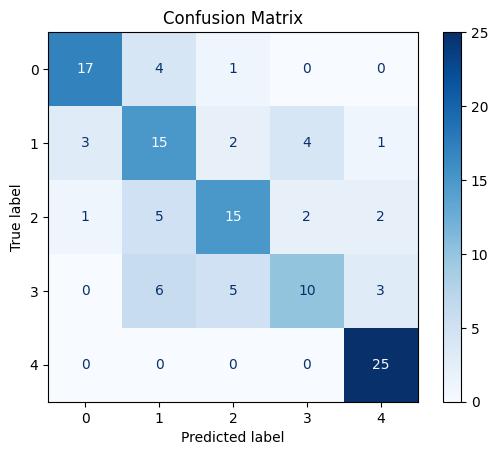

In [48]:
# Predict class probabilities
y_pred_probs = model.predict(X_val)

# Convert to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Optionally set class names: ConfusionMatrixDisplay(..., display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [49]:
#saving X,y for possible later use 
# Save
np.save('X.npy', X)
np.save('y.npy', y)